## Fine-Tune BERT on Sentiment Analysis (Hugging Face)

### Make Exploratory Data Analysis (EDA) on the loaded dataset

In [5]:
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords

# Download the NLTK stopwords corpus if not already present
nltk.download("stopwords")

# Create a set of English stopwords for later use
stop_words = set(stopwords.words("english"))

# 1. Load dataset (e.g., IMDb movie reviews)
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42)  # Reduce size for demo

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/developer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from datasets import load_dataset
import pandas as pd

# 1. Load IMDb Dataset
dataset = load_dataset("imdb")

# Explore the dataset before splitting
print(dataset)

# Access the splits
train_data = pd.DataFrame(dataset["train"]) # type: ignore
test_data = pd.DataFrame(dataset["test"]) # type: ignore
unsupervised_data = pd.DataFrame(dataset["unsupervised"]) # type: ignore

print("Train shape:", train_data.shape)  # Include: train and validation
print("Test shape:", test_data.shape)
print("Unsupervised shape", unsupervised_data.shape)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Train shape: (25000, 2)
Test shape: (25000, 2)
Unsupervised shape (50000, 2)


In [7]:
# 2. Basic Info
print("📊 Dataset Shape:", train_data.shape)
print("📝 Sample Data:\n", train_data.sample(5))
print("🧾 Class Distribution:\n", train_data["label"].value_counts())

📊 Dataset Shape: (25000, 2)
📝 Sample Data:
                                                     text  label
8503   When I noticed that "Hamish Macbeth" was being...      0
17679  Steven Spielberg produced, wrote, came up with...      1
1551   Personally, while I'm able to appreciate reall...      0
3113   This really was the worst movie I have ever se...      0
20329  I probably saw this movie first in about 1995....      1
🧾 Class Distribution:
 label
0    12500
1    12500
Name: count, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split

all_data = pd.concat(
    [
        pd.DataFrame(dataset["train"]), # type: ignore
        pd.DataFrame(dataset["test"]), # type: ignore
    ],
    ignore_index=True,
)

# Split all_data into train + test (65/35)
train_df, test_df = train_test_split(
    all_data, test_size=0.35, stratify=all_data["label"], random_state=42
)

print("Train set:", train_df.shape)
print("Test set:", test_df.shape)

Train set: (32500, 2)
Test set: (17500, 2)


In [10]:
print(train_df.head())
print(test_df.head())

                                                    text  label
29919  PERHAPS SPOILER !! well, i ve seen it at the f...      0
11266  If you like films that ramble with little plot...      0
48870  Begotten.The magic.The Terror.The slight bored...      1
8915   Sort of family parody blending "An Officer And...      0
34949  This movie is supposed to take place in Milfor...      0
                                                    text  label
5798   Being a fan of silent films, I looked forward ...      0
40904  GREAT, Chris Diamantopoulos has got to be the ...      1
11859  I saw this on DVD ( It`s known as CORRUPT in t...      0
27694  What a shame. This could have been good. The m...      0
3167   I have done quite a few reviews on IMDb and th...      0


In [11]:
# 3. Rename label for clarity
train_df["label"] = train_df["label"].map({0: "negative", 1: "positive"})
test_df["label"] = test_df["label"].map({0: "negative", 1: "positive"})

In [12]:
print(train_df.head())
print(test_df.head())

                                                    text     label
29919  PERHAPS SPOILER !! well, i ve seen it at the f...  negative
11266  If you like films that ramble with little plot...  negative
48870  Begotten.The magic.The Terror.The slight bored...  positive
8915   Sort of family parody blending "An Officer And...  negative
34949  This movie is supposed to take place in Milfor...  negative
                                                    text     label
5798   Being a fan of silent films, I looked forward ...  negative
40904  GREAT, Chris Diamantopoulos has got to be the ...  positive
11859  I saw this on DVD ( It`s known as CORRUPT in t...  negative
27694  What a shame. This could have been good. The m...  negative
3167   I have done quite a few reviews on IMDb and th...  negative


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32500 entries, 29919 to 26224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    32500 non-null  object
 1   label   32500 non-null  object
dtypes: object(2)
memory usage: 761.7+ KB


/tmp/ipykernel_181027/1742132709.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="label", palette="Set2")


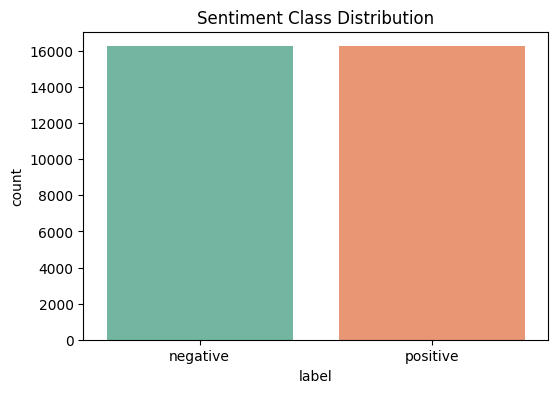

In [15]:
# 4. Visualize Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x="label", palette="Set2")
plt.title("Sentiment Class Distribution")
plt.show()

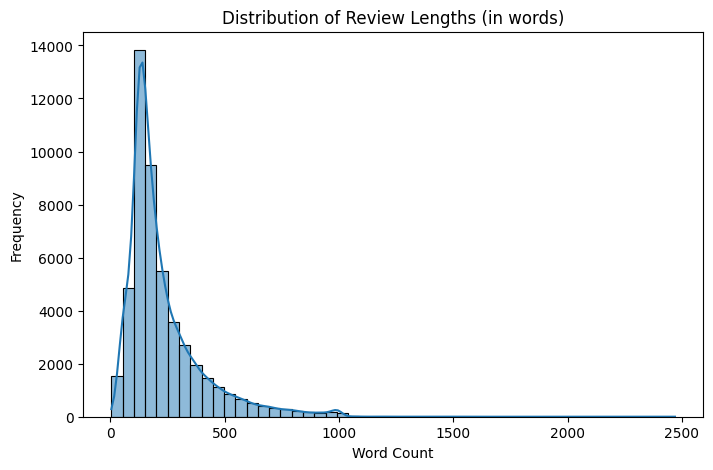

In [16]:
# 5. Text Length Analysis
all_data["text_length"] = all_data["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data=all_data, x="text_length", bins=50, kde=True)
plt.title("Distribution of Review Lengths (in words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

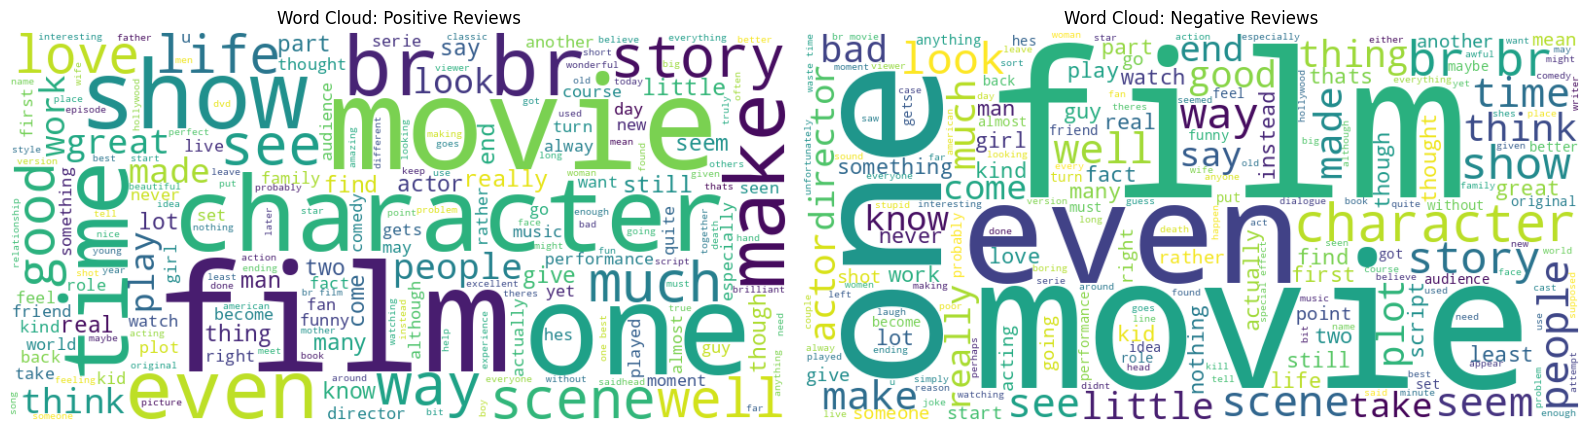

In [17]:
from wordcloud import WordCloud
import string


# 6. WordClouds for Positive and Negative Reviews

def preprocess_text(text):
    """
    Preprocess the input text by:
    - Lowercasing all characters
    - Removing punctuation
    - Removing stopwords and non-alphabetic tokens
    Returns a cleaned string.
    """
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    words = text.split()  # Split text into words
    # Remove stopwords and non-alphabetic tokens, then join back to string
    return " ".join([word for word in words if word not in stop_words and word.isalpha()])

# Concatenate all positive review texts after preprocessing
positive_text = " ".join(
    all_data[all_data["label"] == 1]["text"].apply(preprocess_text)
)

# Concatenate all negative review texts after preprocessing
negative_text = " ".join(
    all_data[all_data["label"] == 0]["text"].apply(preprocess_text)
)

# Plot word clouds for positive and negative reviews
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with 2 subplots

# Generate and plot word cloud for positive reviews
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
axs[0].imshow(wordcloud_pos, interpolation="bilinear")  # Display the word cloud image
axs[0].axis("off")  # Hide axes
axs[0].set_title("Word Cloud: Positive Reviews")  # Set subplot title

# Generate and plot word cloud for negative reviews
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_text)
axs[1].imshow(wordcloud_neg, interpolation="bilinear")  # Display the word cloud image
axs[1].axis("off")  # Hide axes
axs[1].set_title("Word Cloud: Negative Reviews")  # Set subplot title

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()  # Display the plots


### (Optional) Step-by-Step: IMDb Train / Validation / Test Split
- *This option of splittig the data will be taken in the model tokenizer*

In [2]:
from datasets import load_dataset
import pandas as pd

# Load the IMDb dataset from Hugging Face
dataset = load_dataset("imdb")

# Convert 'train' and 'test' splits to DataFrames
df_train_full = pd.DataFrame(dataset["train"])  # type: ignore # 25,000 samples
df_test = pd.DataFrame(dataset["test"])  # type: ignore # 25,000 samples

In [3]:
from sklearn.model_selection import train_test_split

# Split train into train (80%) and validation (20%)
df_train, df_val = train_test_split(
    df_train_full,
    test_size=0.2,
    stratify=df_train_full["label"],  # keep label distribution balanced
    random_state=42,
)

# Show shapes
print("✅ Final Splits:")
print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

✅ Final Splits:
Train: (20000, 2)
Validation: (5000, 2)
Test: (25000, 2)


### Tokenize the dataset

In [4]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
)
import torch
# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Currently we're trying to tokenize the original dataset object (which contains the un-split Hugging Face dataset), while your actual working DataFrames are df_train, df_val, and df_test.

- To tokenize your custom splits, you should either:

    - Convert the Pandas DataFrames back into Hugging Face Dataset objects.
    - Tokenize using the tokenizer directly on DataFrames.

In [5]:
from datasets import Dataset

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 20000
})
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 5000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [6]:
# 3. Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
train_encoded = train_dataset.map(tokenize, batched=True)
val_encoded = val_dataset.map(tokenize, batched=True)
test_encoded = test_dataset.map(tokenize, batched=True)

Map: 100%|██████████| 25000/25000 [00:51<00:00, 485.60 examples/s]


In [8]:
# Set format to PyTorch tensors
train_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [9]:
import torch

print(torch.version.cuda)  # type: ignore
print(torch.cuda.is_available())
print(torch.cuda.device_count())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("CUDA not available")

12.6
True
1
NVIDIA GeForce RTX 4060 Laptop GPU


In [10]:
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments
from sklearn.metrics import accuracy_score
import numpy as np


# ✅ Define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Use all available data for training and evaluation
train_dataset = train_encoded
eval_dataset = val_encoded

# ✅ Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    eval_strategy="epoch",  # <-- Add this line
    save_strategy="epoch",  # <-- Add this line
    eval_steps=100,  # Evaluate every 100 steps (adjust as needed)
    save_steps=500,  # Save checkpoint every 500 steps (adjust as needed)
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    no_cuda=False,  # <-- Force CPU usage
)

# ✅ Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# ✅ Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.254900,0.295944,0.917600
2,0.364700,0.269595,0.931800
3,0.154900,0.373892,0.933400


TrainOutput(global_step=7500, training_loss=0.19469704529295365, metrics={'train_runtime': 4269.6533, 'train_samples_per_second': 14.053, 'train_steps_per_second': 1.757, 'total_flos': 1.57866633216e+16, 'train_loss': 0.19469704529295365, 'epoch': 3.0})

### Plotting the evolution of metrics (loss & accuracy) over training steps

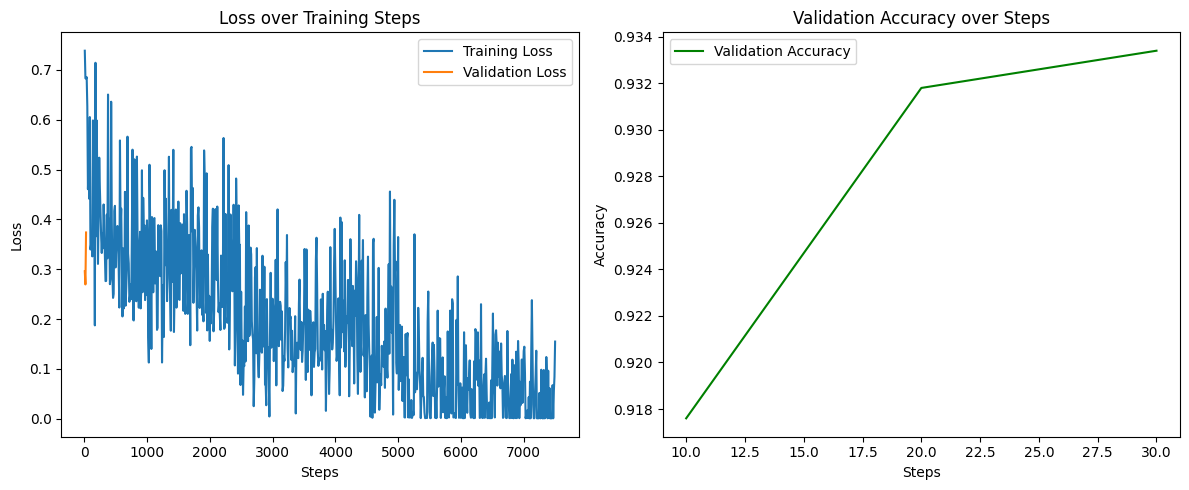

In [11]:
import matplotlib.pyplot as plt

# Extract logged history
logs = trainer.state.log_history

# Prepare lists for plotting
steps = []
train_loss = []
eval_loss = []
eval_accuracy = []

for entry in logs:
    if "loss" in entry and "step" in entry:
        train_loss.append(entry["loss"])
        steps.append(entry["step"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])

# Plot training & evaluation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps[: len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss over Training Steps")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(
    steps[: len(eval_accuracy)],
    eval_accuracy,
    label="Validation Accuracy",
    color="green",
)
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Steps")
plt.legend()

plt.tight_layout()
plt.show()

#### Plotting training, validation, and test accuracy in a single graph

✅ Test Accuracy: 0.93404


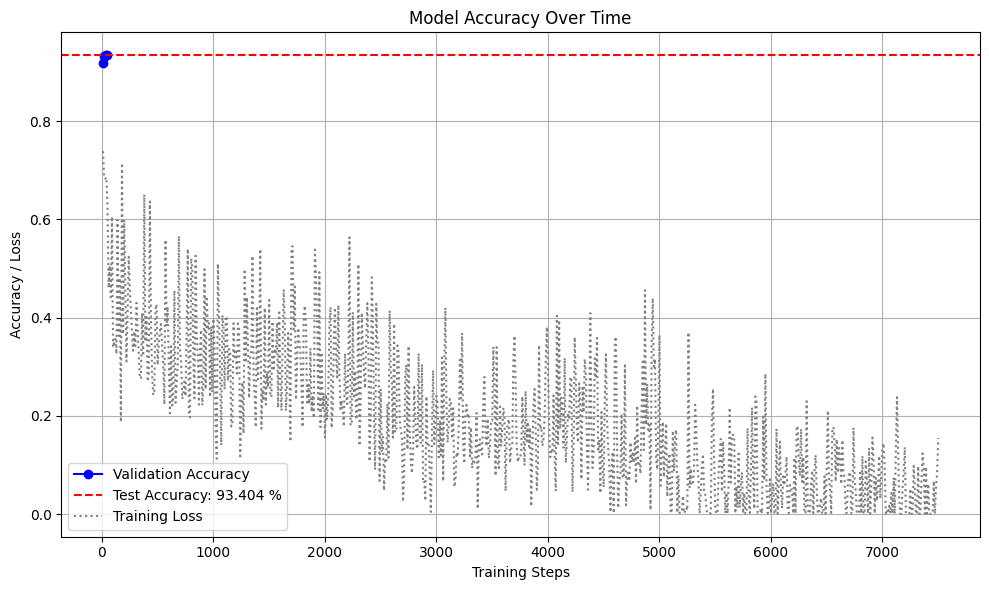

In [13]:
import matplotlib.pyplot as plt

# Step 1: Evaluate on test dataset after training
test_metrics = trainer.evaluate(test_encoded) # type: ignore
test_accuracy = test_metrics["eval_accuracy"]
print("✅ Test Accuracy:", test_accuracy)

# Step 2: Extract from log history
logs = trainer.state.log_history
train_steps, train_loss, val_loss, val_accuracy = [], [], [], []

for entry in logs:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    if 'eval_accuracy' in entry:
        val_accuracy.append(entry['eval_accuracy'])
    if 'eval_loss' in entry:
        val_loss.append(entry['eval_loss'])

# Step 3: Plot accuracy
plt.figure(figsize=(10, 6))

# Plot validation accuracy
plt.plot(train_steps[:len(val_accuracy)], val_accuracy, label="Validation Accuracy", marker='o', color='blue')

# Plot test accuracy as horizontal line
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f"Test Accuracy: {100*test_accuracy:.3f} %")

# Optional: Plot training loss curve (for reference)
plt.plot(train_steps, train_loss, label="Training Loss", linestyle='dotted', color='gray')

plt.xlabel("Training Steps")
plt.ylabel("Accuracy / Loss")
plt.title("Model Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Save and load the best model after training

In [14]:
# Save the best model (automatically loaded at end due to `load_best_model_at_end=True`)
trainer.save_model("./results/best_model")  # ✅ This saves the model weights + config
tokenizer.save_pretrained("./results/best_model")  # ✅ Save tokenizer

('./results/best_model/tokenizer_config.json',
 './results/best_model/special_tokens_map.json',
 './results/best_model/vocab.txt',
 './results/best_model/added_tokens.json')

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("./results/best_model")
tokenizer = AutoTokenizer.from_pretrained("./results/best_model")